# ADAPT QAOA
The notebook demonstrates the solution of a generic optimization problem using both the "vanilla" QAOA (Quantum Approximate Optimization Algorithm) and the adaptive version

### Hamiltonian encoding
The optimization  objective function is encoded into a Hamiltonian function formulated as a weighted sum of Pauli strings:  
$$H = \sum_k{c_kP_k}$$

with each pauli string, $P_k$, composed of a Pauli operation ($\sigma\in\left\{I,X,Y,Z\right\}$) applied to each of the qubits in the register.

For example, $XIIZ$, applies a Pauli $X$ to the first qubit and a Pauli $Z$ to the fourth qubit

The encoding of the objective start by defining the function with binary variables, $x_i\in\left\{1,-1\right\}$, and then defining Pauli strings with $Z_i$ corresponding to the original variables. If the objective variables' domain is $x_i\in\left\{0,1\right\}$, a transformation is used: $x_i=\left(1-Z_i\right)/2$ (commonly referred to as _spin to bit_ transformation)  

Since the encoding results in Pauli strings composed only of $I$, and $Z$, the Pauli string is called _diagonal_, this has the following benefits:
* **Easy exponentiation** - the exponentiation results in simple to implement single or multi-qubit Z rotations
* **No superposition mixing** - the diagonal Hamiltonian does not create entanglement or rotate between basis states, enabling computation basis measurement
* **Efficient measurement** - all $\left\{I,Z\right\}^{\otimes n}$ strings commute, allowing for a single simultaneous measurement of all strings

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy
from tqdm import tqdm

from classiq import *

#### QMod tip
In the following cell the variable `h` is set to a diagonal hamiltonian using a self explanatory syntax that sums sparse Pauli strings, that is only the non identity Paulis are specified. For example the first line, `- 0.1247375 * Pauli.Z(0) * Pauli.Z(1)` creates the string `ZZIII` with the weight `-0.1247375`. The length of the string, is inferred from the largest qubit index in the sum. The resulating variable has the type [SparsePauliOp](https://docs.classiq.io/latest/qmod-reference/api-reference/classical-types/?h=sparsepauliop#classiq.qmod.builtins.structs.SparsePauliOp)

For the optimization function a _dual-use_ function is used for the Hamiltonian. This function takes a argument that can be either a `QArray` or a `list[int]`. This allows the same function to be used both to:
* compute the cost expectation on the measurement results which are binary numbers ($0,1$)
* create a quantum observable in the circuit, resulting in quantum gates

the additional `cost_func` function negates the `hamiltonian` function since the problem involves finding the maximum value, but the optimization procedure (`scipy.optimize.minimize`) performs a minimization

In [2]:
from typing import Tuple

from sympy import sympify

from classiq import IndexedPauli, Pauli, SparsePauliOp, SparsePauliTerm
from classiq.qmod.symbolic_expr import SymbolicExpr

QFloatExr = SymbolicExpr


h = (
    -0.561775 * Pauli.Z(0)
    - 1.238125 * Pauli.Z(1)
    - 1.131450 * Pauli.Z(2)
    - 0.681350 * Pauli.Z(3)
    - 0.713775 * Pauli.Z(4)
    - 0.979450 * Pauli.Z(5)
    - 1.145025 * Pauli.Z(6)
    - 0.774450 * Pauli.Z(7)
    + 0.5 * Pauli.Z(0) * Pauli.Z(1)
    + 0.5 * Pauli.Z(0) * Pauli.Z(2)
    - 0.188125 * Pauli.Z(0) * Pauli.Z(4)
    - 0.200100 * Pauli.Z(0) * Pauli.Z(5)
    + 0.5 * Pauli.Z(1) * Pauli.Z(3)
    + 0.234550 * Pauli.Z(1) * Pauli.Z(6)
    + 0.053575 * Pauli.Z(1) * Pauli.Z(7)
    + 0.5 * Pauli.Z(2) * Pauli.Z(3)
    - 0.048100 * Pauli.Z(2) * Pauli.Z(4)
    + 0.229550 * Pauli.Z(2) * Pauli.Z(5)
    - 0.039525 * Pauli.Z(3) * Pauli.Z(6)
    - 0.229125 * Pauli.Z(3) * Pauli.Z(7)
    + 0.5 * Pauli.Z(4) * Pauli.Z(5)
    + 0.5 * Pauli.Z(4) * Pauli.Z(6)
    + 0.5 * Pauli.Z(5) * Pauli.Z(7)
    + 0.5 * Pauli.Z(6) * Pauli.Z(7)
)


def hamiltonian(v: QArray | list[int]) -> QFloatExr:
    # linear Z_i coefficients (diagonal of hh)
    single_weights = [
        -0.561775,  # Z0
        -1.238125,  # Z1
        -1.13145,  # Z2
        -0.68135,  # Z3
        -0.713775,  # Z4
        -0.97945,  # Z5
        -1.145025,  # Z6
        -0.77445,  # Z7
    ]

    # quadratic ZZ coefficients (off-diagonal of hh for i<j)
    quadratic_pairs = [
        (0, 1),
        (0, 2),
        (0, 4),
        (0, 5),
        (1, 3),
        (1, 6),
        (1, 7),
        (2, 3),
        (2, 4),
        (2, 5),
        (3, 6),
        (3, 7),
        (4, 5),
        (4, 6),
        (5, 7),
        (6, 7),
    ]
    quadratic_weights = [
        0.5,
        0.5,
        -0.188125,
        -0.2001,
        0.5,
        0.23455,
        0.053575,
        0.5,
        -0.0481,
        0.22955,
        -0.039525,
        -0.229125,
        0.5,
        0.5,
        0.5,
        0.5,
    ]

    def z_value(bit: int | QBit) -> QFloatExr:
        # maps v_i in {0,1} to Z_i in {+1,-1}
        return sympify(1.0) - 2 * bit

    ham = sympify(0.0)  # no constant term in your SparsePauliOp

    # ZZ terms
    for (i, j), w in zip(quadratic_pairs, quadratic_weights):
        ham += w * z_value(v[i]) * z_value(v[j])

    # Z terms
    for i, w in enumerate(single_weights):
        ham += w * z_value(v[i])

    return ham


def cost_func(v: QArray | list[int]) -> QFloatExr:
    return hamiltonian(v)  # negative sign for maximization

#### The Cost Layer
As mentioned above, since the Hamiltonian is diagonal, its exponentiation is straightforward and amounts to phase addition due to Z rotations.  
This is accomplished with the [phase](https://docs.classiq.io/latest/qmod-reference/language-reference/statements/phase/?h=phase) function, which results in an efficient quantum implementation of $e^{-i \gamma H_c}$.

In [3]:
@qfunc
def cost_layer(gamma: CReal, v: QArray):
    phase(cost_func(v), gamma)

#### The Mixer Layer
The QAOA mixer is defined as $H_M=\sum{X_i}$, and its exponentiaion is simply a $R_X$ rotation of the same angle ($\beta$) on all the qubits

In [4]:
@qfunc
def mixer_layer(beta: CReal, qba: QArray):
    apply_to_all(lambda q: RX(2 * beta, q), qba)

#### The QAOA Ansatz
The parametric QAOA ansatz is composed of $p$ pairs of exponentiated Mixer and Cost Hamiltonians:  
$$U\left(\vec{\beta},\vec{\gamma}\right)=e^{-i \beta_p H_M}e^{-i \gamma_p H_C}\ldots e^{-i \beta_2 H_M}e^{-i \gamma_1 H_C}e^{-i \beta_2 H_M}e^{-i \gamma_1 H_C}$$

In [5]:
@qfunc
def qaoa_ansatz(
    gammas: CArray[CReal],
    betas: CArray[CReal],
    qba: QArray,
):
    n = gammas.len
    assert n == betas.len, "Number of gamma and beta parameters must be equal"
    for i in range(n):
        cost_layer(gammas[i], qba)
        mixer_layer(betas[i], qba)

### Assemble the full QAOA algorithm
We select $p=3$ layers for the QAOA. The quantum program takes the $2p$ parameters as a single list (because the `scipy.optimize.minimize` function manipulate a 1-D array of parameters), and the quantum register of the $5$ qubits.

The qubits are initialized to $\left|+\right\rangle^{\otimes 5}$, with a `hadamard_transform` and then the `qaoa_ansatz`, $U\left(\vec{\beta},\vec{\gamma}\right)$, is applied

In [6]:
from typing import Final

NUM_LAYERS: Final[int] = 3
NUM_QUBITS: Final[int] = 8


@qfunc
def main(
    params: CArray[
        CReal, NUM_LAYERS * 2  # type: ignore
    ],  # Execution parameters (first half: gammas, second half: betas)
    v: Output[QArray[QBit, NUM_QUBITS]],  # type: ignore
):
    allocate(v)
    hadamard_transform(v)
    gammas = params[0:NUM_LAYERS]
    betas = params[NUM_LAYERS : NUM_LAYERS * 2]

    qaoa_ansatz(gammas, betas, v)

In [7]:
from classiq.execution.execution_session import ExecutionSession
from classiq.synthesis import show, synthesize

custom_hardware_settings = CustomHardwareSettings(basis_gates=["cz", "rz", "rx", "ry"])
#     connectivity_map = [
#     (0, 1), (1, 2), (2, 3),
#     (4, 5), (5, 6), (6, 7),
#     (0, 4), (1, 5), (2, 6), (3, 7)
# ],
#     is_symmetric_connectivity=True,
# )
preferences = Preferences(custom_hardware_settings=custom_hardware_settings)

write_qmod(main, name="adapt_qaoa", decimal_precision=15, symbolic_only=False)
qprog = synthesize(main, preferences=preferences)

es = ExecutionSession(qprog)
# show(qprog)

In [8]:
# circuit width
print(f"circuit width: {qprog.data.width}")
# circuit depth
print(f"circuit depth: {qprog.transpiled_circuit.depth}")

circuit width: 8
circuit depth: 241


## Classical Optimization - "Vanilla" QAOA
The $\vec{\beta}$, and $\vec{\gamma}$ parameters are tuned until the objective function converges.

The results of the parameters, and the solution vector are shown below

In [9]:
cost_trace = []
params_history = []


def objective_func(params, es):
    cost_estimation = es.estimate_cost(
        lambda state: cost_func(state["v"]), {"params": params.tolist()}
    )
    cost_trace.append(cost_estimation)
    params_history.append(params.copy())
    return cost_estimation

In [10]:
# TODO: uncomment
MAX_ITERATIONS = 60

initial_params = np.concatenate(
    (np.linspace(0, 1, NUM_LAYERS), np.linspace(1, 0, NUM_LAYERS))
)

with tqdm(total=MAX_ITERATIONS, desc="Optimization Progress", leave=True) as pbar:

    def progress_bar(xk: np.ndarray) -> None:
        pbar.update(1)

    obj = lambda params: objective_func(params, es)

    optimization_results = scipy.optimize.minimize(
        fun=obj,
        x0=initial_params,
        method="COBYLA",
        options={"maxiter": MAX_ITERATIONS},
        callback=progress_bar,
    )

# Sample the circuit using the optimized parameters
res = es.sample({"params": optimization_results.x.tolist()})
es.close()

print(f"Optimized parameters: {optimization_results.x.tolist()}")

Optimization Progress:  40%|███████████████████████████████▏                                              | 24/60 [01:26<02:10,  3.62s/it]


Optimized parameters: [0.023764076850575737, 0.4788895138030138, 1.999274060087544, 0.9995157762026724, 0.4815685457228382, 0.09300073147966786]


Plotting the convergence graph: 

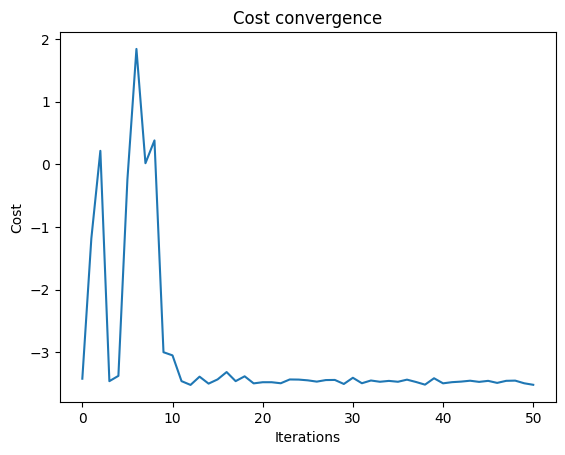

In [11]:
plt.plot(cost_trace)
plt.xlabel("Iterations")
plt.ylabel("Cost")
plt.title("Cost convergence")
plt.show()

## Displaying and Discussing the Results

In [12]:
print(f"Optimized parameters: {optimization_results.x.tolist()}")
sorted_counts = sorted(res.parsed_counts, key=lambda pc: cost_func(pc.state["v"]))
num_shots = sum(state.shots for state in res.parsed_counts)
for sampled in sorted_counts[:10]:
    solution = sampled.state["v"]
    probability = sampled.shots / num_shots
    cost_value = cost_func(solution)
    print(f"solution={solution} probability={probability:.3f} cost={cost_value:.3f}")

Optimized parameters: [0.023764076850575737, 0.4788895138030138, 1.999274060087544, 0.9995157762026724, 0.4815685457228382, 0.09300073147966786]
solution=[1, 0, 0, 1, 1, 0, 0, 1] probability=0.037 cost=-5.482
solution=[1, 0, 0, 1, 0, 1, 1, 0] probability=0.012 cost=-4.771
solution=[1, 0, 0, 1, 0, 0, 0, 1] probability=0.021 cost=-4.629
solution=[0, 0, 0, 1, 1, 0, 0, 1] probability=0.014 cost=-4.629
solution=[0, 0, 0, 1, 0, 0, 0, 1] probability=0.031 cost=-4.529
solution=[1, 0, 0, 1, 0, 1, 0, 0] probability=0.026 cost=-4.513
solution=[1, 0, 0, 0, 0, 1, 1, 0] probability=0.020 cost=-4.513
solution=[1, 0, 0, 0, 1, 0, 0, 1] probability=0.017 cost=-4.465
solution=[1, 0, 0, 1, 1, 0, 0, 0] probability=0.013 cost=-4.465
solution=[1, 0, 0, 0, 0, 1, 0, 0] probability=0.042 cost=-4.413


# ADAPT QAOA
The algorithm, based on the paper [An adaptive quantum approximate optimization algorithm for solving combinatorial problems on a quantum computer](https://arxiv.org/pdf/2005.10258), modifies QAOA by using different _mixer_ layers, instead of the original $H_M=\sum_i{X_i}$.

The algorithm defines a pool of potential mixer layers, that are simple to implement, and can match the problem better. The motiviation to the algorithm is rooted in t _STA_ (shortcut to adiabaticity), with the hope of achieving better convergence than the "vanilla" QAOA.

The algorithm proceeds incrementally:
* initially, a single mixer layer is used (the original $H_M$) and the parameters are optimized
* all the potential mixer layers, $A_j$, are tested as candidates. The criterion is the resulting gradient of the commutator of a potential mixer layer with the cost Hamiltonian, applied to the current circuit:
$$\nabla A_j = \left\langle\psi^{\left(k-1\right)}\right|e^{i \gamma_0 H_C}\left[H_C,A_j\right]e^{-i \gamma_0 H_C}\left|\psi^{\left(k-1\right)}\right\rangle$$
* the mixer layer with the largest gradient is selected, the circuit grows by one layer, and the process continues (optimizing parameters and checking gradients)
* the process terminates when the scaled norm of the gradient vector drops below a threshold

#### Utilities
The following functions define some convenience utilities for computing the commutation of Pauli strings

In [13]:
from functools import reduce
from operator import add, mul

# the following utilites are used to compute an expectation value of the form:
# <psi | [A,H] | psi>
# where psi is the state (ansatz), A and H are a mixer and cost Hamiltonians, respectively
# defined as pauli strings (SparsePauliOp)

# multiplication table of two Pauli matrices
# weight (imaginary), pauli_c = pauli_a * pauli_b
pauli_mult_table: list[list[Tuple[int, int]]] = [
    [(+0, Pauli.I), (+0, Pauli.X), (+0, Pauli.Y), (+0, Pauli.Z)],
    [(+0, Pauli.X), (+0, Pauli.I), (+1, Pauli.Z), (-1, Pauli.Y)],
    [(+0, Pauli.Y), (-1, Pauli.Z), (+0, Pauli.I), (+1, Pauli.X)],
    [(+0, Pauli.Z), (+1, Pauli.Y), (-1, Pauli.X), (+0, Pauli.I)],
]


def sorted_pauli_term(term: SparsePauliTerm) -> SparsePauliTerm:
    """
    sort pauli terms according to the qubit's index, e.g.,
    Pauli.X(2)*Pauli.Z(7)*Pauli.X(4) ==> Pauli.X(2)*Pauli.X(4)*Pauli.Z(7)
    """
    sorted_paulis = sorted(term.paulis, key=lambda p: p.index)
    return SparsePauliTerm(sorted_paulis, term.coefficient)


def commutator(ha: SparsePauliOp, hb: SparsePauliOp) -> SparsePauliOp:
    """
    Compute the commutator [ha, hb] = ha*hb - hb*ha
    where ha and hb are SparsePauliOp objects.
    Returns a SparsePauliOp representing the commutator.
    """
    n = max(ha.num_qubits, hb.num_qubits)
    commutation = SparsePauliOp([], n)

    for sp_term_a in ha.terms:
        for sp_term_b in hb.terms:
            parity = 1
            coefficient = 1.0
            msp = {p.index: p.pauli for p in sp_term_a.paulis}
            for p in sp_term_b.paulis:
                pauli_a = msp.get(p.index, Pauli.I)
                pauli_b = p.pauli
                weight, pauli = pauli_mult_table[pauli_a][pauli_b]
                if weight != 0:
                    parity = -parity
                    coefficient *= weight * 1j
                msp[p.index] = pauli
            # reconstruct pauli_string
            if parity != 1:
                # consider filtering identity terms, making sure the term is not empty
                pauli_term = (reduce(mul, (p(idx) for idx, p in msp.items()))).terms[0]
                pauli_term.coefficient = (
                    sp_term_a.coefficient * sp_term_b.coefficient * coefficient * 2
                )
                commutation.terms.append(pauli_term)
    return commutation


def normalize_pauli_term(spt: SparsePauliTerm, num_qubits=-1) -> SparsePauliTerm:
    """
    remove redundant Pauli.I operators from a Pauli string
    making "normalized" strings comparable
    if num_qubits is set, an optional Pauli.I is added to ensure the length
    """
    if not spt.paulis:
        return spt

    npt = sorted_pauli_term(spt)

    paulis = []
    max_index = max_identity_index = -1
    if num_qubits > 0:
        max_identity_index = num_qubits - 1
    for ip in npt.paulis:
        if ip.pauli != Pauli.I:
            paulis.append(ip)
            max_index = max(max_index, int(ip.index))
        else:
            max_identity_index = max(max_identity_index, int(ip.index))

    if max_identity_index > max_index:
        paulis.append(IndexedPauli(Pauli.I, max_identity_index))

    npt.paulis = paulis
    return npt


def collect_pauli_terms(spo: SparsePauliOp) -> SparsePauliOp:
    """
    collect the coefficient of identical Pauli strings
    for example: 1.5*"IXZI"-0.3*"IXXZ"+0.4*"IXZI", would result, in:
    1.9*"IXZI"-0.3*"IXXZ"
    The function correctly ignores "I" when comparing strings,
    and sets the correct `num_qubits`
    terms with abs(coefficient)<TOLERANCE are dropped
    """
    TOLERANCE: Final[float] = 1e-10
    pauliterms = {}
    for term in spo.terms:
        npt = normalize_pauli_term(term, spo.num_qubits)
        key = tuple((ip.pauli, int(ip.index)) for ip in npt.paulis)
        pauliterms[key] = pauliterms.get(key, 0) + term.coefficient

    def single_qubit_op(pair: tuple[int, int]) -> SparsePauliOp:
        p_int, idx = pair
        term = SparsePauliTerm([IndexedPauli(Pauli(p_int), idx)], 1.0)
        return SparsePauliOp([term], num_qubits=idx + 1)

    paulistrings = []
    for key, coeff in pauliterms.items():
        if np.abs(coeff) < TOLERANCE:
            continue
        key_op = reduce(mul, (single_qubit_op(pair) for pair in key))
        paulistrings.append(coeff * key_op)

    if not paulistrings:
        return SparsePauliOp([], spo.num_qubits)

    # Sum all strings
    return reduce(add, paulistrings)

### The Mixer Pool
The pool includes the default sum-of-X layer, as well as a sum-of-Y layer, followed by several single qubit layers with X and Y Paulis, and some two-qubit gates that add entanglement at the cost of a slightly more complicated layer.

Several heuristics are suggested for building mixer pools based on the problem definition.

A larger pool has a potential to find more efficient circuits, at the cost of computing many _mixer gradients_ at each iteration

In [14]:
# # build mixer pool
# mixer_pool: list[SparsePauliOp] = [
#     # default mixer
#     0.2
#     * (
#           Pauli.X(0)
#         + Pauli.X(1)
#         + Pauli.X(2)
#         + Pauli.X(3)
#         + Pauli.X(4)
#     ),
#     # Y mixer
#     0.2
#     * (
#           Pauli.Y(0)
#         + Pauli.Y(1)
#         + Pauli.Y(2)
#         + Pauli.Y(3)
#         + Pauli.Y(4)
#     ),
#     # single qubit mixers
#     1.0 * Pauli.X(0),
#     1.0 * Pauli.X(1),
#     1.0 * Pauli.X(2),
#     1.0 * Pauli.X(3),
#     1.0 * Pauli.X(4),
#     1.0 * Pauli.Y(0),
#     1.0 * Pauli.Y(1),
#     1.0 * Pauli.Y(2),
#     1.0 * Pauli.Y(3),
#     1.0 * Pauli.Y(4),
#     # two qubit mixers
#     1.0 * Pauli.X(0) * Pauli.X(1),
#     1.0 * Pauli.X(0) * Pauli.X(2),
#     1.0 * Pauli.X(0) * Pauli.X(3),
#     1.0 * Pauli.X(0) * Pauli.X(4),
#     1.0 * Pauli.X(1) * Pauli.X(2),
#     1.0 * Pauli.X(1) * Pauli.X(3),
#     1.0 * Pauli.X(1) * Pauli.X(4),
#     1.0 * Pauli.X(2) * Pauli.X(3),
#     1.0 * Pauli.X(2) * Pauli.X(4),
#     1.0 * Pauli.X(3) * Pauli.X(4),
#     1.0 * Pauli.Y(0) * Pauli.Y(1),
#     1.0 * Pauli.Y(0) * Pauli.Y(2),
#     1.0 * Pauli.Y(0) * Pauli.Y(3),
#     1.0 * Pauli.Y(0) * Pauli.Y(4),
#     1.0 * Pauli.Y(1) * Pauli.Y(2),
#     1.0 * Pauli.Y(1) * Pauli.Y(3),
#     1.0 * Pauli.Y(1) * Pauli.Y(4),
#     1.0 * Pauli.Y(2) * Pauli.Y(3),
#     1.0 * Pauli.Y(2) * Pauli.Y(4),
#     1.0 * Pauli.Y(3) * Pauli.Y(4),
# ]


# for 8 qubits
# build mixer pool for 8 qubits
mixer_pool: list[SparsePauliOp] = [
    # default X mixer (global)
    1.0
    * (
        Pauli.X(0)
        + Pauli.X(1)
        + Pauli.X(2)
        + Pauli.X(3)
        + Pauli.X(4)
        + Pauli.X(5)
        + Pauli.X(6)
        + Pauli.X(7)
    ),
    # default Y mixer (global)
    1.0
    * (
        Pauli.Y(0)
        + Pauli.Y(1)
        + Pauli.Y(2)
        + Pauli.Y(3)
        + Pauli.Y(4)
        + Pauli.Y(5)
        + Pauli.Y(6)
        + Pauli.Y(7)
    ),
    # single-qubit X mixers
    1.0 * Pauli.X(0),
    1.0 * Pauli.X(1),
    1.0 * Pauli.X(2),
    1.0 * Pauli.X(3),
    1.0 * Pauli.X(4),
    1.0 * Pauli.X(5),
    1.0 * Pauli.X(6),
    1.0 * Pauli.X(7),
    # single-qubit Y mixers
    1.0 * Pauli.Y(0),
    1.0 * Pauli.Y(1),
    1.0 * Pauli.Y(2),
    1.0 * Pauli.Y(3),
    1.0 * Pauli.Y(4),
    1.0 * Pauli.Y(5),
    1.0 * Pauli.Y(6),
    1.0 * Pauli.Y(7),
    # two-qubit XX mixers (all pairs i<j)
    1.0 * Pauli.X(0) * Pauli.X(1),
    1.0 * Pauli.X(0) * Pauli.X(2),
    1.0 * Pauli.X(0) * Pauli.X(3),
    1.0 * Pauli.X(0) * Pauli.X(4),
    1.0 * Pauli.X(0) * Pauli.X(5),
    1.0 * Pauli.X(0) * Pauli.X(6),
    1.0 * Pauli.X(0) * Pauli.X(7),
    1.0 * Pauli.X(1) * Pauli.X(2),
    1.0 * Pauli.X(1) * Pauli.X(3),
    1.0 * Pauli.X(1) * Pauli.X(4),
    1.0 * Pauli.X(1) * Pauli.X(5),
    1.0 * Pauli.X(1) * Pauli.X(6),
    1.0 * Pauli.X(1) * Pauli.X(7),
    1.0 * Pauli.X(2) * Pauli.X(3),
    1.0 * Pauli.X(2) * Pauli.X(4),
    1.0 * Pauli.X(2) * Pauli.X(5),
    1.0 * Pauli.X(2) * Pauli.X(6),
    1.0 * Pauli.X(2) * Pauli.X(7),
    1.0 * Pauli.X(3) * Pauli.X(4),
    1.0 * Pauli.X(3) * Pauli.X(5),
    1.0 * Pauli.X(3) * Pauli.X(6),
    1.0 * Pauli.X(3) * Pauli.X(7),
    1.0 * Pauli.X(4) * Pauli.X(5),
    1.0 * Pauli.X(4) * Pauli.X(6),
    1.0 * Pauli.X(4) * Pauli.X(7),
    1.0 * Pauli.X(5) * Pauli.X(6),
    1.0 * Pauli.X(5) * Pauli.X(7),
    1.0 * Pauli.X(6) * Pauli.X(7),
    # two-qubit YY mixers (all pairs i<j)
    1.0 * Pauli.Y(0) * Pauli.Y(1),
    1.0 * Pauli.Y(0) * Pauli.Y(2),
    1.0 * Pauli.Y(0) * Pauli.Y(3),
    1.0 * Pauli.Y(0) * Pauli.Y(4),
    1.0 * Pauli.Y(0) * Pauli.Y(5),
    1.0 * Pauli.Y(0) * Pauli.Y(6),
    1.0 * Pauli.Y(0) * Pauli.Y(7),
    1.0 * Pauli.Y(1) * Pauli.Y(2),
    1.0 * Pauli.Y(1) * Pauli.Y(3),
    1.0 * Pauli.Y(1) * Pauli.Y(4),
    1.0 * Pauli.Y(1) * Pauli.Y(5),
    1.0 * Pauli.Y(1) * Pauli.Y(6),
    1.0 * Pauli.Y(1) * Pauli.Y(7),
    1.0 * Pauli.Y(2) * Pauli.Y(3),
    1.0 * Pauli.Y(2) * Pauli.Y(4),
    1.0 * Pauli.Y(2) * Pauli.Y(5),
    1.0 * Pauli.Y(2) * Pauli.Y(6),
    1.0 * Pauli.Y(2) * Pauli.Y(7),
    1.0 * Pauli.Y(3) * Pauli.Y(4),
    1.0 * Pauli.Y(3) * Pauli.Y(5),
    1.0 * Pauli.Y(3) * Pauli.Y(6),
    1.0 * Pauli.Y(3) * Pauli.Y(7),
    1.0 * Pauli.Y(4) * Pauli.Y(5),
    1.0 * Pauli.Y(4) * Pauli.Y(6),
    1.0 * Pauli.Y(4) * Pauli.Y(7),
    1.0 * Pauli.Y(5) * Pauli.Y(6),
    1.0 * Pauli.Y(5) * Pauli.Y(7),
    1.0 * Pauli.Y(6) * Pauli.Y(7),
]

The gradient of a mixer is computed by taking the circuit, $e^{-i \gamma_0 H_C}\left|\psi^{\left(k-1\right)}\right\rangle$, provided by the `es` execution session and the `params`, and measuring the commutation of the mixer with the Hamiltonian:
$$\nabla A_j=\left\langle\psi^{\left(k-1\right)}\right|e^{i \gamma_0 H_C}\left[H_C,A_j\right] e^{-i \gamma_0 H_C}\left|\psi^{\left(k-1\right)}\right\rangle$$

In [15]:
def grad_mixer(
    mixer: SparsePauliOp,
    hamiltonian: SparsePauliOp,
    es: ExecutionSession,
    params: list[float],
) -> float:
    mix_h_comm = commutator(mixer, hamiltonian)
    return abs(es.estimate(mix_h_comm, {"params": params}).value)

## Classical Optimization - ADAPT QAOA

The implementation of the ADAPT QAOA uses the same hybrid quantum-classical structure to optimize the ansatz parameters ($\vec{\beta},\vec{\gamma}$)
The differences are:
* The `ansatz mixers` list is incrementally populated with mixer layers, and used in the ansatz
* Following each convergence, the gradients of all mixers are computed, and either a new mixer is added, or the adaptive process concludes

#### QMod tip
Since the mixer is no longer a sum of single bit Pauli strings (the default mixer can be written as: $XII\ldots I+IXI\ldots I+IIX\ldots I+III\ldots X$), the exponent is not a trivial Pauli rotation (applying $R_X\left(\beta\right)$ to each qubit) and the exponentiation $e^{-i \beta A_j}$ has to be computed.  

An efficient and simple construct is the [suzuki_trotter](https://docs.classiq.io/latest/qmod-reference/api-reference/functions/core_library/exponentiation/?h=suzuki_trotter#classiq.qmod.builtins.functions.exponentiation.commuting_paulis_exponent) function that exponentiates a `SparsePauliOp` (a weighted sum of Pauli strings) with a given coefficient.

The `adaptive_mixer_layer` function uses this construct: `suzuki_trotter(ansatz_mixers[mixer_idx], beta, 1, 1, qba)`, where the third and fourth arguments (`1,1`) specify the order and number of repetitions of the trotterization, which can be safely set to $1$ for simple Pauli strings.

Another variant is the [multi_suzuki_trotter](https://docs.classiq.io/latest/qmod-reference/api-reference/functions/core_library/exponentiation/?h=multi_suzuki_trotter#classiq.qmod.builtins.functions.exponentiation.multi_suzuki_trotter) function that exponentiates a sum of Hamiltonians: $e^{-i\left(H_1t_1+H_2t_2+\ldots+H_nt_n\right)}$

In [ ]:
from classiq import suzuki_trotter
from classiq.execution import ClassiqBackendPreferences, ExecutionPreferences

MAX_ITERATIONS = 60

last_params = []

ansatz_mixers: list[int] = []
# start with default mixer
ansatz_mixers.append(0)


# gradient norm tolerance for stopping criterion
tol: Final[float] = 0.027

while True:  # loop until gradient norm exceeds tolerance (break-ing out of the loop)
    # number of layers (initially=1), each layer is a pair of mixer and cost Hamiltonians

    # TODO: remove the next two lines
    # ansatz_mixers.append(0)
    # ansatz_mixers.append(0)
    p = len(ansatz_mixers)

    # adiabatic inspired initialization of beta and gamma
    initial_params = np.concatenate((np.linspace(0, 1, p), np.linspace(1, 0, p)))

    # trace and history for analysis and plotting
    cost_trace = []
    params_history = []

    @qfunc
    def adaptive_mixer_layer(mixer_idx: int, beta: CReal, qba: QArray):
        suzuki_trotter(mixer_pool[ansatz_mixers[mixer_idx]], beta, 1, 1, qba)

    @qfunc
    def qaoa_adaptive_ansatz(
        gammas: CArray[CReal],
        betas: CArray[CReal],
        qba: QArray,
    ):
        n = gammas.len
        assert n == betas.len, "Number of gamma and beta parameters must be equal"
        print(f"Building ansatz with {n} layers.")
        for i in range(n):
            cost_layer(gammas[i], qba)
            adaptive_mixer_layer(i, betas[i], qba)

    @qfunc
    def main(
        params: CArray[
            CReal, p * 2  # type: ignore
        ],  # Execution parameters (first half: gammas, second half: betas), used later by the sample method
        v: Output[QArray[QBit, NUM_QUBITS]],  # type: ignore
    ):
        allocate(v)
        hadamard_transform(v)
        gammas = params[0:p]
        betas = params[p : p * 2]
        qaoa_adaptive_ansatz(gammas, betas, v)

    custom_hardware_settings = CustomHardwareSettings(
        basis_gates=["cz", "rz", "rx", "ry"]
    )
    # connectivity_map = [
    #     (0, 1), (1, 2), (2, 3),
    #     (4, 5), (5, 6), (6, 7),
    #     (0, 4), (1, 5), (2, 6), (3, 7)
    # ],
    #         is_symmetric_connectivity=True,
    #     )
    preferences = Preferences(custom_hardware_settings=custom_hardware_settings)

    qprog = synthesize(main, preferences=preferences)

    with ExecutionSession(
        quantum_program=qprog,
        execution_preferences=ExecutionPreferences(
            backend_preferences=ClassiqBackendPreferences(
                backend_name="simulator"
            )  # _statevector")
        ),
    ) as es:
        with tqdm(
            total=MAX_ITERATIONS,
            desc=f"Optimization Progress for {p} layered circuit",
            leave=True,
        ) as pbar:

            def progress_bar(xk: np.ndarray) -> None:
                pbar.update(1)

            def obj(params):
                return objective_func(params, es)

            optimization_results = scipy.optimize.minimize(
                fun=obj,
                x0=initial_params,
                method="COBYLA",
                options={"maxiter": MAX_ITERATIONS, "rhobeg": 0.5},
                callback=progress_bar,
            )

    print(
        f"Completed optimization for {p} layered circuit. objective value: {optimization_results.fun}"
    )

    params = optimization_results.x.tolist()
    last_params = params[:]  # copy for final execution

    # break
    # TODO: remove
    # ansatz_mixers.append(mixer_pool[0])

    # if p >= 3:
    #     break

    # compute gradients of mixer pool elements
    gamma_0 = 0.01  # (or any value below 0.1)

    @qfunc
    def main(
        params: CArray[
            CReal, p * 2  # type: ignore
        ],  # Execution parameters (first half: gammas, second half: betas), used later by the sample method
        v: Output[QArray[QBit, NUM_QUBITS]],  # type: ignore
    ):
        allocate(v)
        hadamard_transform(v)
        gammas = params[0:p]
        betas = params[p : p * 2]

        qaoa_adaptive_ansatz(gammas, betas, v)
        cost_layer(gamma_0, v)

    print("Computing mixer gradients...")
    custom_hardware_settings = CustomHardwareSettings(
        basis_gates=["cz", "rz", "rx", "ry"]
    )
    #     connectivity_map = [
    #     (0, 1), (1, 2), (2, 3),
    #     (4, 5), (5, 6), (6, 7),
    #     (0, 4), (1, 5), (2, 6), (3, 7)
    # ],
    #     is_symmetric_connectivity=True,
    # )
    preferences = Preferences(custom_hardware_settings=custom_hardware_settings)

    qprog_grads = synthesize(main, preferences=preferences)
    # qprog = synthesize(qmod, preferences=prefs)
    #
    # # non-transpiled / logical QASM
    # logical_qasm = qprog.qasm
    #
    # # transpiled QASM (if transpilation_option ≠ NONE)
    # transpiled_qasm = None
    # if qprog.transpiled_circuit is not None:
    #     transpiled_qasm = qprog.transpiled_circuit.qasm  # <-- THIS
    #
    # # Transpiled QASM (hardware circuit), if transpilation is enabled:
    # transpiled_qasm =qprog.transpiled_circuit.qasm
    # transpiled_qasm =qprog.transpiled_circuit.logigal_to_physical_input_qubit_map
    # mapping = qprog.data.qubit_mapping
    # #logical = mapping.logical_outputs
    # physical = mapping.physical_outputs
    # print(physical)

    with ExecutionSession(qprog_grads) as es:
        gradients = np.abs(
            np.array([grad_mixer(mp, h, es, params) for mp in mixer_pool])
        )

    scaled_gradient_norm = np.linalg.norm(gradients) / len(gradients)
    print(f"{scaled_gradient_norm=}")

    if scaled_gradient_norm < tol:
        break

    g_idx = np.argmax(gradients)
    print(f"Selected mixer index: {g_idx}")

    ansatz_mixers.append(g_idx)

Building ansatz with 1 layers.


Optimization Progress for 1 layered circuit:  38%|█████████████████████▍                                  | 23/60 [00:56<01:30,  2.45s/it]


Completed optimization for 1 layered circuit. objective value: -3.54461806640625
Computing mixer gradients...
Building ansatz with 1 layers.
scaled_gradient_norm=np.float64(0.03471585218988072)
Selected mixer index: 0
Building ansatz with 2 layers.


Optimization Progress for 2 layered circuit:  45%|█████████████████████████▏                              | 27/60 [01:21<01:39,  3.02s/it]


Completed optimization for 2 layered circuit. objective value: -3.54333486328125
Computing mixer gradients...
Building ansatz with 2 layers.
scaled_gradient_norm=np.float64(0.04703661991770519)
Selected mixer index: 1
Building ansatz with 3 layers.


Optimization Progress for 3 layered circuit:  50%|████████████████████████████                            | 30/60 [01:38<01:38,  3.29s/it]


Completed optimization for 3 layered circuit. objective value: -3.7976916992187504
Computing mixer gradients...
Building ansatz with 3 layers.


In [ ]:
with ExecutionSession(qprog) as es:
    # Sample the circuit using the optimized parameters
    res = es.sample({"params": last_params})

Plotting the convergence graph: 

In [ ]:
plt.plot(cost_trace)
plt.xlabel("Iterations")
plt.ylabel("Cost")
plt.title("Cost convergence")
plt.show()

In [ ]:
res.dataframe

In [ ]:
# h = (
#     - 0.1247375 * Pauli.Z(0) * Pauli.Z(1)
#     - 0.1747375 * Pauli.Z(0)
#     - 0.1207125 * Pauli.Z(1) * Pauli.Z(2)
#     - 0.2954500 * Pauli.Z(1)
#     - 0.1163000 * Pauli.Z(2) * Pauli.Z(3)
#     - 0.2870125 * Pauli.Z(2)
#     - 0.1247125 * Pauli.Z(3) * Pauli.Z(4)
#     - 0.2910125 * Pauli.Z(3)
#     - 0.1747125 * Pauli.Z(4)
#     + 1.7093000 * Pauli.I(0)
# )

In [ ]:
print(f"Optimized parameters: {optimization_results.x.tolist()}")
sorted_counts = sorted(res.parsed_counts, key=lambda pc: cost_func(pc.state["v"]))
num_shots = sum(state.shots for state in res.parsed_counts)
for sampled in sorted_counts[:10]:
    solution = sampled.state["v"]
    probability = sampled.shots / num_shots
    cost_value = cost_func(solution)
    print(f"solution={solution} probability={probability:.3f} cost={cost_value:.3f}")

In [ ]:
res.dataframe.sort_values(by="probability", ascending=False)